# Do Colleges Gentrify Boston?

### Project Group 6: Nathan Kirschner, Sebastian Kobori, Sarah Lang, Caleb Lee

Gentrification is a process where wealthy people move into an area, raising rent and housing prices and pushing out the original residents displace low-income families or, more often, prevent low-income families from moving into previously affordable neighborhoods

### Why we chose this as our project:
> * Boston is a “collegetown”, with 27 colleges & 50,000 students in the city of Boston
> * Boston is a city with severe gentrification (Smith)
> * Boston is ranked 3rd most in the nation
> * 21.3% of the city is gentrified from 2013-2017

### Hypothesis : 
> Students may move to a neighborhood to attend a college in an adjacent neighborhood, thus raising the living standard of that area. The more college students, the higher prices.

### Our research question: 
> Do the presence of colleges in Boston increase the change in median gross rent in the surrounding area?

### Goal: 
- Create a dataframe where each row represents a unique tract (CT-ID) and the columns describe that tract (percent change in median gross rent, total student population in tract, average net price of colleges in tract)
- Use this dataframe to create graphs, where each point represents a unique tract
- Total student population vs percent change in median gross rent
- Average net price vs percent change in median gross rent


### Plan: 
- Pull 5 year census data (2010-2014) as a dataframe where each row represents a unique tract and the columns descibe that tract in terms of CT-ID, Median Gross Rent and Total Population
- Pull 5 year census data (2015-2019) as a dataframe where each row represents a unique tract and the columns descibe that tract in terms of CT-ID, Median Gross Rent and Total Population
- Gather data on all the schools in Suffolk county through the NCES's CollegeNavigator tool, compile into excel
- Read the excel file with college data where each row represents a college, and columns describe that college (CT-ID, Student Population, Net price) as a dataframe
- Aggregate the college data, grouping by CT-ID, such that each row now represents a unique tract instead of a college and the columns describe that tract in terms of CT-ID, average net price and total student population of colleges in that tract
- Merge all 3 dataframes by CT-ID, and create a new column for the percent difference in median gross rent between the 2010-2014 data and the 2015-2019 data. 
- Use matplotlib for the graphs

Tools: pandas, geopandas, censusdata API, excel, mathplotlib

In [1]:
!pip install censusdata

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore") #to surpress DataFrame copy warnings
import censusdata

We first had to figure out how to pull census data for Massachusetts. The state number for MA is 25.

In [3]:
states2014 = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
print(states2014['Massachusetts'])
states2019 = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2019)
print(states2019['Massachusetts'])

Summary level: 040, state:25
Summary level: 040, state:25


We also had to figure out how to pull census data for Boston specifically. For the purposes of our experiment, we defined Boston to only include Suffolk County. The county number for Suffolk is 025.

In [4]:
counties2014 = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2014)
print(counties2014)
counties2019 = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2019)
print(counties2019)

{'Barnstable County, Massachusetts': censusgeo((('state', '25'), ('county', '001'))), 'Berkshire County, Massachusetts': censusgeo((('state', '25'), ('county', '003'))), 'Plymouth County, Massachusetts': censusgeo((('state', '25'), ('county', '023'))), 'Norfolk County, Massachusetts': censusgeo((('state', '25'), ('county', '021'))), 'Nantucket County, Massachusetts': censusgeo((('state', '25'), ('county', '019'))), 'Suffolk County, Massachusetts': censusgeo((('state', '25'), ('county', '025'))), 'Dukes County, Massachusetts': censusgeo((('state', '25'), ('county', '007'))), 'Middlesex County, Massachusetts': censusgeo((('state', '25'), ('county', '017'))), 'Bristol County, Massachusetts': censusgeo((('state', '25'), ('county', '005'))), 'Hampden County, Massachusetts': censusgeo((('state', '25'), ('county', '013'))), 'Essex County, Massachusetts': censusgeo((('state', '25'), ('county', '009'))), 'Franklin County, Massachusetts': censusgeo((('state', '25'), ('county', '011'))), 'Worcest

We then needed to figure out the codes for the variables that corresponded to total population and median gross rent. We used google for this.

In [5]:
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B01003')) #total population
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B25064')) #median gross rent

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B01003_001E  | B01003.  Total Population      | Total                                                    | int  
-------------------------------------------------------------------------------------------------------------------
Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B25064_001E  | B25064.  Median Gross Rent (Do | Median gross rent                                        | int  
-------------------------------------------------------------------------------------------------------------------


To avoid issues with running cells out of order and creating mutation issues, we made a function that sets all dateframes to a known state. We used our findings above (about state, county, and variable codes) to pull the information we wanted from the Census API, from the 5 year estimate 2010-2014 and the 5 year estimate 2015-2019. However, when we pulled the data, it was not in the form we wanted; it was a dataframe where each row represented a block instead of a tract. Since blocks are subgroups of tracts, there were multiple rows that represented the same tract. In addition, there was no column for CT-ID, but rather a long string that contained pieces of a CT-ID. So we needed to create another method to convert the raw data into usable data, where each row represented a unique tract instead of block, with the columns still describing total population and median gross rent, but for the tract instead of the block. 

In [6]:
boston_data_2014  = ''
boston_data_2019 = ''

#sets all dataframes to a known state
def initData():
    global boston_data_2014
    global boston_data_2019
    
    boston_data_2014 = censusdata.download('acs5', 2014,
           censusdata.censusgeo([('state', '25'),
                                 ('county', '025'),
                                 ('block group', '*')]),
          ['B01003_001E', 'B25064_001E'])


    boston_data_2014 = convert_raw_census(boston_data_2014)
    
    boston_data_2019 = censusdata.download('acs5', 2019,
           censusdata.censusgeo([('state', '25'),
                                 ('county', '025'),
                                 ('block group', '*')]),
          ['B01003_001E', 'B25064_001E'])

    boston_data_2019 = convert_raw_census(boston_data_2019)
    



Our first step of converting raw data was renaming the column names from the raw data, which were previously just numbers and letters. The next order of business was dealing with missing data. We made the decision that if a given row did not have a population (nan) we gave it a value of 0. We did the same for rows without median gross rent (when doing calculations with this data, we recognized zero as sentinel value). In addition, we encountered an error where certain rows contained median gross rent values that were negative. So we set those to 0 as well. Next, we created the CT-ID column by using string manipulation on the corresponding row in the raw tract column. Finally, we aggregated block data into tract data. Given that multiple blocks could correspond to the same CT-ID, we used group by on CT-ID, summing the populations and taking a weighted sum of the median gross rents for the blocks in the given CT-ID group. This gave us two dataframes: one with CT-ID and total population, the other with CT-ID and median gross rent. In both, each row represented a unique tract, not a block. We then merged these two by CT-ID, thus completing our conversion from raw census data to the form we wanted.

In [7]:
#for the given df, grouped by CT-ID, sums the population
def total_pop(df):
    return df['TotalPop'].sum()

#for the given df, grouped by CT-ID, finds the weighted sum of median gross rent 
def weighted_gross_rent(df):
    df.reset_index(inplace=True)
    #the total population in the blocks in this CT-ID group
    normal = total_pop(df)
    sum = 0
    for i in range(df.shape[0]):
        #the population of one block
        pop = df['TotalPop'][i]
        #the proportion of this block 
        weight = pop / normal
        #the median gross rent of this block
        rent = df['Median_Gross_Rent'][i]
        #weighted 
        sum += rent * weight
    return sum


#given a df of raw boston census data from a given year,
#returns a new dataframe with updated column names and a new CT-ID column
def convert_raw_census(df):
    df.reset_index(inplace=True)
    df.rename(columns={"B01003_001E": "TotalPop",
                           "B25064_001E": "Median_Gross_Rent", "index": "raw_tract"}, inplace=True)
    
    #a design decisions
    df["TotalPop"] = df["TotalPop"].fillna(0)
    df["Median_Gross_Rent"] = df["Median_Gross_Rent"].fillna(0)
    
    
    
    #make a new column for CT_ID_10, initialized as a copy 
    df['CT-ID-10'] = df['raw_tract']
    
    for i in range(df.shape[0]):
        
        #dealing with negative rents
        #by setting them to 0
        if df['Median_Gross_Rent'][i] < 0:
            df['Median_Gross_Rent'][i] = 0
            
        #the current CT-ID    
        curr = df['CT-ID-10'][i]
        curr = str(curr)
        
        #where the tract ID is located
        start = curr.index('tract') + 6
        end = start + 6
        
        #substring
        tract_ID  = curr[start: end]
 
        #all have the same state and county ID with prefix 25025
        CT_ID = "25025" + str(tract_ID)
        CT_ID = int(CT_ID)
        
        #replace the entries of CT_ID_10 with the actual value
        df['CT-ID-10'][i] = CT_ID
    
    total_pop_table = df.groupby('CT-ID-10').apply(total_pop)
    max_rent_table = df.groupby('CT-ID-10').apply(weighted_gross_rent)
    total_pop_df = total_pop_table.rename_axis('CT-ID-10').reset_index(name='TotalPop')
    max_rent_df = avg_rent_table = max_rent_table.rename_axis('CT-ID-10').reset_index(name='Median_Gross_Rent')
    result = total_pop_df.merge(max_rent_df, how = 'left', on = 'CT-ID-10')
    return result
    

We tested our raw data conversion on the 2010-2014 pull, and it was a success.

In [8]:
initData()
print("Total population of Suffolk County 2014: " + str(boston_data_2014.TotalPop.sum()))
print("Total tracts: " + str(boston_data_2014.shape[0]))
boston_data_2014.head()

Total population of Suffolk County 2014: 747928
Total tracts: 204


,CT-ID-10,TotalPop,Median_Gross_Rent
0,25025000100,3264,1514.267770
1,25025000201,3073,1691.745200
2,25025000202,3482,1426.505744
3,25025000301,2437,1682.533032
4,25025000302,2673,1741.272727


We then tested our raw data conversion on the 2014-2019 pull, and it was also a success.

In [9]:
initData()
print("Total population of Suffolk County 2019: " + str(boston_data_2019.TotalPop.sum()))
print("Total tracts: " + str(boston_data_2019.shape[0]))
boston_data_2019.head()

Total population of Suffolk County 2019: 796605
Total tracts: 204


,CT-ID-10,TotalPop,Median_Gross_Rent
0,25025000100,5884,1786.764616
1,25025000201,4125,2297.036364
2,25025000202,4461,1653.422551
3,25025000301,3074,2348.629473
4,25025000302,3447,2254.574993


The next thing we did was generate our college data, by reading the excel file we made as a dataframe. We made the decision to drop all rows that has Na for net price. (To clarify, net price is the cost of attending the school factoring in finanical aid/scholarships). We also used string manipulation to convert all values in the net price column to integers. 

In [10]:
college_data = pd.read_excel("collegesInBoston.xlsx")

#we cannot analyze a college if it has missing data 
college_data = college_data.dropna(subset = ['Net Price **'])

college_data.reset_index(inplace=True)

#converting the prices from string format to integer format
for row in range(len(college_data)):
    price_as_string = str(college_data['Net Price **'][row])
    if "," in price_as_string:
        comma_index = price_as_string.index(",")
        clean = price_as_string[1: comma_index] + price_as_string[comma_index+1:]
    else:
        clean = price_as_string[1:]
    college_data['Net Price **'][row] = int(clean)

college_data.head()

,index,Name,Address,Website,Type,Awards offered,Campus setting,Campus housing,Student population,Undergraduate students,Graduation Rate,Transfer-Out Rate,Cohort Year *,Net Price **,Largest Program,IPEDS ID,OPE ID,CT-ID-10
0,0,North Bennet Street School,"150 North Street, Boston, Massachusetts 02109",www.nbss.edu/,"2-year, Private not-for-profit",One but less than two years certificate;Two bu...,City: Large,No,157,157.0,72%,NaN,Fall 2016,32019,Furniture Design and Manufacturing,167297,2197900,25025030400
1,1,Suffolk University,"73 Tremont St., Boston, Massachusetts 02108-3901",https://www.suffolk.edu/,"4-year, Private not-for-profit",One but less than two years certificate;Associ...,City: Large,Yes,7169,4862.0,58%,29%,Fall 2013,33105,-,168005,221800,25025070101
2,2,Empire Beauty School-Boston,"30 West Street, Boston, Massachusetts 02111",www.empire.edu/,"< 2-year, Private for-profit",One but less than two years certificate,City: Large,No,139,139.0,58%,NaN,2016-17,17053,"Cosmetology/Cosmetologist, General",164845,817807,25025010701
3,3,Boston Architectural College,"320 Newbury Street, Boston, Massachusetts 0211...",www.the-bac.edu/,"4-year, Private not-for-profit",Less than one year certificate;Bachelor's degr...,City: Large,Yes,737,364.0,13%,33%,Fall 2013,26640,-,164872,396600,25025010701
4,4,Emmanuel College,"400 The Fenway, Boston, Massachusetts 02115",www.emmanuel.edu/,"4-year, Private not-for-profit",Bachelor's degree;Postbaccalaureate certificat...,City: Large,Yes,2222,2112.0,66%,NaN,Fall 2013,29946,-,165671,214700,25025010300


However, similar to the block issue from the raw census data, each row in our college dataframe did not represent a unique tract, but rather an individual college. Therefore, multiple rows could have the same CT-ID if multiple colleges were located there. To deal with this, we used a similar conversion process that we did on the raw census data. We grouped by CT-ID, taking the sum of the student populations and the average net price. This gave us two dataframes with rows representing unique tracts, one  with CT-ID and total student population, and the other with CT-ID and average net price. We then merged these two by CT-ID, thus completing our conversion.

In [11]:
#the average net price
def avg_price(df):
    count = df.shape[0]
    return df["Net Price **"].sum() / count

#the sum of student populations for all colleges in the given CT-ID group
def total_students(df):
    return df['Student population'].sum()

avg_tuition_prices_table = college_data.groupby('CT-ID-10').apply(avg_price)

total_students_table = college_data.groupby('CT-ID-10').apply(total_students)

avg_tuition_prices_per_tract = avg_tuition_prices_table.rename_axis('CT-ID-10').reset_index(name='avg_net_price')

total_students_per_tract = total_students_table.rename_axis('CT-ID-10').reset_index(name='total_student_pop')

In [12]:
avg_tuition_prices_per_tract.head()

,CT-ID-10,avg_net_price
0,25025010103,29479.00
1,25025010300,31271.75
2,25025010405,42281.00
3,25025010701,21846.50
4,25025010801,23981.00


In [13]:
total_students_per_tract.head()

,CT-ID-10,total_student_pop
0,25025010103,33720
1,25025010300,18218
2,25025010405,30049
3,25025010701,876
4,25025010801,1628


We displayed our converted college dataframe, which was a success. 

In [14]:
relevant_college_data = avg_tuition_prices_per_tract.merge(total_students_per_tract, how = 'left', on = 'CT-ID-10')

relevant_college_data.head()

,CT-ID-10,avg_net_price,total_student_pop
0,25025010103,29479.00,33720
1,25025010300,31271.75,18218
2,25025010405,42281.00,30049
3,25025010701,21846.50,876
4,25025010801,23981.00,1628


At this point, we needed to merge the converted census dataframes with the converted college dataframe by CT-ID. However, we could not do this just yet, because the census dataframes had far more rows (more unique CT-ID's) than the college dataframe. To handle this, we filtered out all rows from the census dataframes that contained CT-ID's not represented in the college dataframe.

In [15]:
initData()
#all CT-ID's listed in college data
college_tracts = relevant_college_data['CT-ID-10'].tolist()


#returns a filtered version of the given census data
#that contains only CT-ID's listed in college data 
def filterCensus(df):
    for n in range(len(df)):
        test = df['CT-ID-10'][n]
        if not test in college_tracts:
            df = df.drop([n])
    return df

boston_data_2014 = filterCensus(boston_data_2014)

boston_data_2019 = filterCensus(boston_data_2019)

print("The Boston census data now contains only " + str(boston_data_2014.shape[0]) + " relevant tracts")

The Boston census data now contains only 14 relevant tracts


Now that the CT-ID's matched, we were able to merge the 2010-2014 census dataframe and the 2014-2019 census dataframe with the college dataframe.

In [16]:
#merges the given processed census data with the relevant college data
#over the CT-ID column
initData()

def finalize(df):
    result = relevant_college_data.merge(df, how = 'left', on = 'CT-ID-10')
    return result

full_df_2014 = finalize(boston_data_2014)

full_df_2019 = finalize(boston_data_2019)


In [17]:
full_df_2014.rename(columns={"Median_Gross_Rent": "Median_Gross_Rent_2014"}, inplace=True)
full_df_2014.head()


,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2014
0,25025010103,29479.00,33720,3704,1060.298596
1,25025010300,31271.75,18218,5202,1404.483660
2,25025010405,42281.00,30049,5814,549.406261
3,25025010701,21846.50,876,2954,1881.977319
4,25025010801,23981.00,1628,3259,1725.560295


In [18]:
full_df_2019.rename(columns={"Median_Gross_Rent": "Median_Gross_Rent_2019"}, inplace=True)
full_df_2019.head()

,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2019
0,25025010103,29479.00,33720,3686,1717.544493
1,25025010300,31271.75,18218,5351,1404.026163
2,25025010405,42281.00,30049,6008,722.916112
3,25025010701,21846.50,876,2383,2059.597566
4,25025010801,23981.00,1628,3002,2176.054297


Our last step was to create the column for percent change in rent. To do this, we took a slice of the 2014-2019 census dataframe where we only kept the columns CT-ID and Median Gross Rent. We then merged this slice with the pre-existing merge between the 2010-2014 census dataframe and the college dataframe. To calculate percent change in rent, we used the formula (final - initial) / initial, with initial being the median gross rent for 2010-2014 and final being the median gross rent for 2014-2019. 

In [19]:
df_2019_rent = pd.DataFrame(full_df_2019, columns = ['CT-ID-10', 'Median_Gross_Rent_2019']) 
df_2014_19 = full_df_2014.merge(df_2019_rent, how = 'left', on = 'CT-ID-10')
df_2014_19['percent_change_in_rent'] = (df_2014_19['Median_Gross_Rent_2019'] - df_2014_19['Median_Gross_Rent_2014']) * 100 / df_2014_19['Median_Gross_Rent_2014']
df_2014_19.head()


,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2014,Median_Gross_Rent_2019,percent_change_in_rent
0,25025010103,29479.00,33720,3704,1060.298596,1717.544493,61.986869
1,25025010300,31271.75,18218,5202,1404.483660,1404.026163,-0.032574
2,25025010405,42281.00,30049,5814,549.406261,722.916112,31.581339
3,25025010701,21846.50,876,2954,1881.977319,2059.597566,9.437959
4,25025010801,23981.00,1628,3259,1725.560295,2176.054297,26.107115


### Colleges & students 
We realized that just because a student was attending a college, it did not mean that they lived in that same tract. So we ran into the problem where we did not have enough info on student addresses. 

Our solution was to switch from a student centric approach, where we would measure student population vs median gross rent, to a college centric one, where we look at whether the presence of a college affects the rent.

We found all the zip codes in Suffolk County:
http://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?CityKey=2507000&stfips=25&state=ma&stname=Massachusett

Instead of looking up “colleges in Boston” on google, we looked for an accurate list of colleges that are 0 miles from the zip codes of Boston: https://nces.ed.gov/collegenavigator

We then found which tract each college was in from the following website: https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx


Final Excel with list of colleges: https://drive.google.com/file/d/1qt7SUeVnMNHo1JCFY9G9d0Rz8Jzd5QPf/view?usp=sharing

In [20]:
initData()

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
pd.set_option('display.max_columns', None)
import math

map = gpd.read_file('36911d02-d91e-45ef-8b18-c26fa6a747a32020329-1-1pmfndx.pqs7i.dbf')

The shape file we used (https://data.boston.gov/dataset/census-2010-tracts1) included a huge tract filled with water with no people, we needed to manually filter it out in the census’ med gross rent data.

This next map shows a map with the water tract included, and you can see how it skews the data.

For each tract in Boston, if there was a college present, we added one to the 'numColleges' column of our map dataframe. Then we displayed a map with those values, with tracts that have no colleges being black, and tracts with colleges being lighter colors.

<AxesSubplot:>

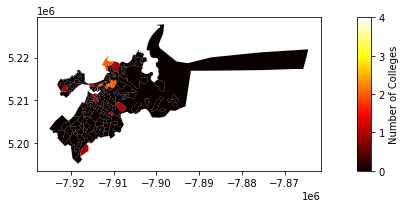

In [21]:
college_data = pd.read_excel("collegesInBoston.xlsx")

map["numColleges"] = 0
for tract in range(len(map)):
    for college in range(len(college_data)):
        if (str(map["GEOID10"][tract]) == str(college_data["CT-ID-10"][college])):
            map["numColleges"][tract] += 1


fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)


map.plot(figsize=(5, 5), column='numColleges', cmap="hot", legend_kwds={'label': "Number of Colleges"}, ax=ax, cax=cax, legend=True)

This is our correct map of tracts with colleges

<AxesSubplot:>

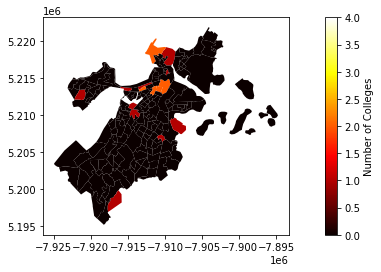

In [22]:
#not including this tract because it's all water
map = map[map["FID"] != 48]

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

map.plot(figsize=(5, 5), column='numColleges', cmap="hot", legend_kwds={'label': "Number of Colleges"}, ax=ax, cax=cax, legend=True)

We added a column for the 2014 median gross rent and 2019 median gross rent.

In [23]:
map = map.reset_index(drop=True)

map["Median_Gross_Rent_14"] = 0
map["Median_Gross_Rent_19"] = 0
for tract_map in range(len(map)):
    for tract_cen in range(len(boston_data_2014)):
        if (str(map["GEOID10"][tract_map]) == str(boston_data_2014["CT-ID-10"][tract_cen])):
            map["Median_Gross_Rent_14"][tract_map] = boston_data_2014["Median_Gross_Rent"][tract_cen]
    for tract_cen in range(len(boston_data_2019)):
        if (str(map["GEOID10"][tract_map]) == str(boston_data_2019["CT-ID-10"][tract_cen])):
            map["Median_Gross_Rent_19"][tract_map] = boston_data_2019["Median_Gross_Rent"][tract_cen]

For some of the tracts, the median gross rent was either missing (NaN) or a negative number, which we belive indicates a missing value in the data set. If that was the case for the 2014 and 2019 data for a particular tract, we assigned that tracts median gross rent to 1 for both years. 

If only one of them was missing/negative, we assigned the year with the missing value to have the same median gross rent as the year that was accurate. This way the change in median gross rent would be zero, so it doesn't interfere with the rest of the data.

In [24]:
for tract in range(len(map)):
    if ((map["Median_Gross_Rent_14"][tract] < 0) or (math.isnan(map["Median_Gross_Rent_14"][tract])) and ((map["Median_Gross_Rent_19"][tract] < 0) or (math.isnan(map["Median_Gross_Rent_19"][tract])))):
        map["Median_Gross_Rent_19"][tract] = 1
        map["Median_Gross_Rent_14"][tract] = 1
    elif ((map["Median_Gross_Rent_19"][tract] < 0) or (math.isnan(map["Median_Gross_Rent_19"][tract]))):
        map["Median_Gross_Rent_19"][tract] = map["Median_Gross_Rent_14"][tract]
    elif ((map["Median_Gross_Rent_14"][tract] < 0) or (math.isnan(map["Median_Gross_Rent_14"][tract]))):
        map["Median_Gross_Rent_14"][tract] = map["Median_Gross_Rent_19"][tract]

This is the equation we used to calculate the percent change in median gross rent from 2014 to 2019.

In [25]:
map["Diff_In_Rent"] = ((map["Median_Gross_Rent_19"] - map["Median_Gross_Rent_14"]) * 100 / map["Median_Gross_Rent_14"])

In [26]:
display(map)

,FID,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape_STAr,Shape_STLe,Shape__Are,Shape__Len,geometry,numColleges,Median_Gross_Rent_14,Median_Gross_Rent_19,Diff_In_Rent
0,1,1,25,025,010405,25025010405,104.05,Census Tract 104.05,G5020,S,363702,0,+42.3398654,-071.0896052,3.914568e+06,14629.550361,6.660999e+05,6036.192858,"POLYGON ((-7913712.352 5213050.565, -7913703.2...",4,549.000000,722.000000,31.511840
1,2,2,25,025,010404,25025010404,104.04,Census Tract 104.04,G5020,S,136829,0,+42.3419667,-071.0886375,1.472714e+06,5277.643216,2.506124e+05,2176.592125,"POLYGON ((-7913776.138 5212012.710, -7913816.8...",0,1579.000000,1762.000000,11.589614
2,3,3,25,025,010801,25025010801,108.01,Census Tract 108.01,G5020,S,127905,0,+42.3541193,-071.0770216,1.376667e+06,6166.497167,2.343579e+05,2542.042976,"POLYGON ((-7912767.027 5214112.033, -7912638.6...",1,1725.000000,2176.000000,26.144928
3,4,4,25,025,010702,25025010702,107.02,Census Tract 107.02,G5020,S,299981,0,+42.3518354,-071.0755159,3.228780e+06,7818.852369,5.496140e+05,3224.572988,"POLYGON ((-7911549.191 5213833.362, -7911526.9...",0,1902.000000,2488.000000,30.809674
4,5,5,25,025,010204,25025010204,102.04,Census Tract 102.04,G5020,S,254706,0,+42.3462887,-071.1033879,2.741497e+06,7621.654206,4.665852e+05,3143.610963,"POLYGON ((-7915575.618 5213366.267, -7915395.1...",0,1500.000000,1882.000000,25.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,177,177,25,025,020301,25025020301,203.01,Census Tract 203.01,G5020,S,256258,328,+42.3631745,-071.0686463,2.761716e+06,10710.510922,4.702803e+05,4418.758815,"POLYGON ((-7910936.934 5215689.769, -7910944.6...",0,1760.145266,2320.400000,31.830028
176,178,178,25,025,020101,25025020101,201.01,Census Tract 201.01,G5020,S,223142,0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,4.088999e+05,3149.451618,"POLYGON ((-7911762.702 5214722.578, -7911736.3...",0,1667.753943,2422.106734,45.231660
177,179,179,25,025,081001,25025081001,810.01,Census Tract 810.01,G5020,S,558488,0,+42.3345666,-071.1068303,6.011082e+06,16640.520998,1.022671e+06,6862.328681,"POLYGON ((-7915356.764 5211150.553, -7915358.8...",0,903.538642,1226.401798,35.733187
178,180,180,25,025,010403,25025010403,104.03,Census Tract 104.03,G5020,S,88556,0,+42.3450750,-071.0880610,9.531475e+05,4227.644208,1.622134e+05,1744.671475,"POLYGON ((-7913685.969 5212702.041, -7913676.5...",0,1475.755723,1671.381402,13.255966


### Plotted the map of Percent Change in Median Gross Rent

Before plotting the change in median gross rent, we removed some of the outliers from the data. One of them was the tract that was only water that we mentioned earlier, which we removed. The other was a change in median gross rent that was much higher than any of the other tracts, making the heat map almost unreadable. To fix this, we made any tract with a change greater than 100% equal to 100%.

<AxesSubplot:>

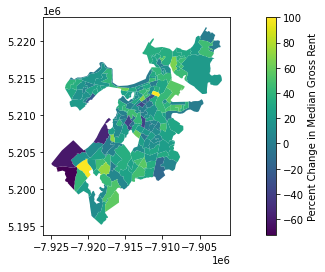

In [27]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

#not including this tract because it's all water
map = map[map["FID"] != 48]

for row in range(len(map)):
    if (map["Diff_In_Rent"][row] > 100):
        map["Diff_In_Rent"][row] = 100

map.plot(figsize=(5, 5), column='Diff_In_Rent', legend_kwds={'label': "Percent Change in Median Gross Rent"}, ax=ax, cax=cax, legend=True)

When comparing the map of colleges in Boston to the change in median gross rent from 2014 to 2019, it would be a stretch to say there was any correlation. We cannot conclusively say that the presence of a school affects gentrification on a tract level in Boston.

Since we couldn't see a correlation in our heat map, we decided to take a closer look using other visualizations. Our first graph was average net price vs percent change in rent from 2014-2019, in only the tracts that had colleges in them. Again, each data point represents a unique tract with at least one college.

Text(0.5, 1.0, 'Relationship between average net price and percent change in rent from 2014-2019')

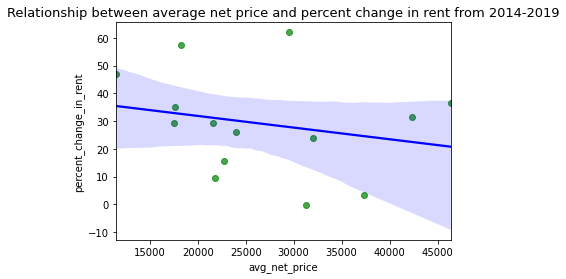

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x='avg_net_price', y='percent_change_in_rent', scatter_kws={"color": "green", 'alpha': 0.7}, line_kws={"color": "blue"}, data=df_2014_19)
plt.title('Relationship between average net price and percent change in rent from 2014-2019', fontsize = 13)

Our second graph was average net price vs percent change in rent from 2014-2019

Text(0.5, 1.0, 'Relationship between total student population and percent change in rent from 2014-2019')

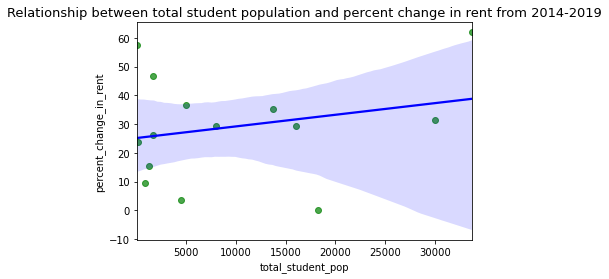

In [29]:
sns.regplot(x='total_student_pop', y='percent_change_in_rent', scatter_kws={"color": "green", 'alpha': 0.7}, line_kws={"color": "blue"}, data=df_2014_19)
plt.title('Relationship between total student population and percent change in rent from 2014-2019', fontsize = 13)

To measure exact correlations, we created a correlation matrix as shown below. 

In [30]:
df_2014_19.corr()

,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2014,Median_Gross_Rent_2019,percent_change_in_rent
CT-ID-10,1.000000,-0.319433,-0.444361,0.325095,-0.351979,-0.266599,0.299794
avg_net_price,-0.319433,1.000000,0.296353,0.390140,-0.555468,-0.664232,-0.231681
total_student_pop,-0.444361,0.296353,1.000000,0.206624,-0.256332,-0.170579,0.246883
TotalPop,0.325095,0.390140,0.206624,1.000000,-0.549469,-0.594431,0.095448
Median_Gross_Rent_2014,-0.351979,-0.555468,-0.256332,-0.549469,1.000000,0.939497,-0.317387
Median_Gross_Rent_2019,-0.266599,-0.664232,-0.170579,-0.594431,0.939497,1.000000,0.005564
percent_change_in_rent,0.299794,-0.231681,0.246883,0.095448,-0.317387,0.005564,1.000000


The cells of this correlation matrix that we are most interested in are the percent change in rent for the average net price and total student pop. 

The net price vs percent change in rent cell shows a negative correlation, which means that tracts with cheaper schools had a larger increase in the change in rent. This goes against our hypothesis that students who pay more for school would contribute more towards gentrification, but it is a weak correlation so it is difficult to draw a meaningful conclusion from this data.

The student population vs percent change in rent is a positive correlation but it's only .247 which is not significant. This means that tracts with larger schools did increase the rent, but only slightly, and not enough to prove our hypothesis.

## Conclusion

Gentrification is a multifacted issue, and we were fully aware that the presence of colleges would not be the only factor affecting median gross rent. Our data did not conclusively show that there is a correlation between the change in median gross rent and the presence of colleges.

>One possible explanation for our lack of a correlation could be that the student population we found doesn't actually tell us how many students are living in the area. Many students don't live in the same tract that their school is in, so they wouldn't contribute to gentrifying the area, in the way we studied it, in that tract. We also don't have data on the breakdown of on campus vs off campus housing for students, nor do we have enough information to understand how off campus vs on campus housing affects gentrification. Using our study methods, we would probably be just analyzing off campus students, however, we recognize that higher demand for on campus housing would potentially cause universities to purchase more property, which would contribute to gentrifying the area. 

>Our sample size, consisting of the 14 tracts that contained the 27 schools in Boston, was quite small. In addition, many of those 27 schools were not standard, 4-year universities, but specialty or trade schools, which we don't imagine would produce the same effect of gentrifying the neighborhood. Both of these factors lead to a high variance in our data which could have contributed to our inconclusive results. Had we chosen a larger area to measure or inluded multiple metropolitan areas, we beleive we could have found a more conclusive relationship between the factors we measured.

>Another possible explanation for our lack of findings could be the 5 year time frame that we chose to use. Most universities in Boston have been around for a long time, so the areas that they are located may have already been gentrified and therefore, the rent would not change as dramatically as if the university had just been established. We don't imagine that a drastically larger amount of students would be coming to attend universities in Boston over the last five years compared to the five years prior. If we wanted to get a better measure of how universities affect gentrifiaction, we could look back further to see if the establishment of a new university, and therefore an increase in student population, would affect the growth in median gross rent.

## Bibliography

Smith, D. (2020, July 09). In a new Study, Boston was ranked the THIRD-MOST Gentrified city 
in the U.S. Retrieved February 04, 2021, from https://www.boston.com/news/local-news-2/2020/07/09/boston-ranked-third-most-gentrified-city.